### Packages

In [ ]:
##SENTIMENT ANALYSIS

In [267]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
import seaborn as sn  
import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 
from tweepy import Stream
from tweepy.streaming import StreamListener
import json
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.model_selection import GridSearchCV


In [296]:
pd.options.display.max_colwidth = 60

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['legend.fontsize'] = 'x-large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'

sn.set_style('darkgrid')
sn.set_context('notebook', font_scale=1.5)

### Data

#### 1. Define functions to tag each tweet into Positive, Negative, Neutral

In [231]:
def clean_tweet(tweet): 
    ''' 
    Utility function to clean tweet text by removing links, special characters using simple regex statements. 
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) 


def get_tweet_sentiment(tweet): 
    ''' 
    Utility function to classify sentiment of passed tweet using textblob's sentiment method 
    '''
    # create TextBlob object of passed tweet text 
    analysis = TextBlob(clean_tweet(tweet)) 
    # set sentiment 
    if analysis.sentiment.polarity > 0: 
        return 'positive'
    elif analysis.sentiment.polarity == 0: 
        return 'neutral'
    else: 
        return 'negative'

#### 2. Download tweets by calling twitter's API and save them into a corpus
(I have already saved the corpus once so I invalidate this part of code)

In [232]:
'''

# consumer key, consumer secret, access token, access secret.
ckey = 'BFUGMgGMDlEAp7qbrhVHAP2QP'
csecret = 'LZcP39uffBb9w4f8QJarYaPyP4REpwBtAuhBh5KP5hwGWUCbND'
atoken = '1126970153441333249-RvYkUBNh91IaU22fZA9NIUWuJ2UqVi'
asecret = 'L3iz8Ats8SMW1dQIGG7skDXoJmdcilyyWB3vlmTiu1orU'

# empty list to store parsed tweets 
tweets_list = [] 

class listener(StreamListener):

    def on_data(self, data):
        parsed_tweet = {}
        
        all_data = json.loads(data)

        tweet = all_data["text"]
        sentiment = get_tweet_sentiment(tweet)
        
        parsed_tweet['text'] = tweet
        parsed_tweet['sentiment'] = sentiment 
        
        tweets_list.append(parsed_tweet)
        return True

    def on_error(self, status):
        print(status) 

auth = OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)
twitterStream = Stream(auth, listener())
twitterStream.filter(track=["car"])

'''

'\n\n# consumer key, consumer secret, access token, access secret.\nckey = \'BFUGMgGMDlEAp7qbrhVHAP2QP\'\ncsecret = \'LZcP39uffBb9w4f8QJarYaPyP4REpwBtAuhBh5KP5hwGWUCbND\'\natoken = \'1126970153441333249-RvYkUBNh91IaU22fZA9NIUWuJ2UqVi\'\nasecret = \'L3iz8Ats8SMW1dQIGG7skDXoJmdcilyyWB3vlmTiu1orU\'\n\n# empty list to store parsed tweets \ntweets_list = [] \n\nclass listener(StreamListener):\n\n    def on_data(self, data):\n        parsed_tweet = {}\n        \n        all_data = json.loads(data)\n\n        tweet = all_data["text"]\n        sentiment = get_tweet_sentiment(tweet)\n        \n        parsed_tweet[\'text\'] = tweet\n        parsed_tweet[\'sentiment\'] = sentiment \n        \n        tweets_list.append(parsed_tweet)\n        return True\n\n    def on_error(self, status):\n        print(status) \n\nauth = OAuthHandler(ckey, csecret)\nauth.set_access_token(atoken, asecret)\ntwitterStream = Stream(auth, listener())\ntwitterStream.filter(track=["car"])\n\n'

In [233]:
'''

# Create a Dataframe to store tweets and sentiments
df = pd.DataFrame({'text':[str(tweet['text']) for tweet in tweets_list for text in tweet],
                  'sentiment':[tweet['sentiment'] for tweet in tweets_list for sentiment in tweet]})

# drop duplicate rows
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)

# Save this DataFrame to csv
df.to_csv('final_data.csv', index=False)

'''

"\n\n# Create a Dataframe to store tweets and sentiments\ndf = pd.DataFrame({'text':[str(tweet['text']) for tweet in tweets_list for text in tweet],\n                  'sentiment':[tweet['sentiment'] for tweet in tweets_list for sentiment in tweet]})\n\n# drop duplicate rows\ndf = df.drop_duplicates()\ndf.reset_index(drop=True, inplace=True)\n\n# Save this DataFrame to csv\ndf.to_csv('final_data.csv', index=False)\n\n"

In [234]:
# Read the csv
data = pd.read_csv('final_data.csv')
Corpus = data.copy()
display(Corpus.head())
print('I collected {} tweets.'.format(len(Corpus)))

,text,sentiment
0,"Eu amo as pessoas que falam que ""ketchup e mai...",positive
1,RT @ElNacionalWeb: #ServicioPúblico Para bebé...,neutral
2,RT @jbem1970: yesterday hubby &amp; I went to ...,negative
3,RT @Chitown_Kid_13: Low-income kids gotta worr...,neutral
4,RT @BABYB0YBANGTAN: when my mom wakes me up fr...,neutral


I collected 3031 tweets.


#### 3. Data pre-processing

In [235]:
import nltk
nltk.download('stopwords')

# Step - a : Remove blank rows if any.
Corpus['text'].dropna(inplace=True)
# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
Corpus['text'] = [entry.lower() for entry in Corpus['text']]
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
Corpus['text']= [word_tokenize(entry) for entry in Corpus['text']]
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(Corpus['text']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    Corpus.loc[index,'text_final'] = str(Final_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xuhuidong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [236]:
Corpus.head()

,text,sentiment,text_final
0,"[eu, amo, as, pessoas, que, falam, que, ``, ke...",positive,"['eu', 'amo', 'pessoas', 'que', 'falam', 'que'..."
1,"[rt, @, elnacionalweb, :, #, serviciopúblico, ...",neutral,"['rt', 'elnacionalweb', 'serviciopúblico', 'pa..."
2,"[rt, @, jbem1970, :, yesterday, hubby, &, amp,...",negative,"['rt', 'yesterday', 'hubby', 'amp', 'go', 'chi..."
3,"[rt, @, chitown_kid_13, :, low-income, kids, g...",neutral,"['rt', 'kid', 'get', 'ta', 'worry', 'go', 'go'..."
4,"[rt, @, babyb0ybangtan, :, when, my, mom, wake...",neutral,"['rt', 'mom', 'wake', 'nap', 'help', 'get', 'g..."


#### 4. Split the corpus into a training set and a validation set

In [237]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(Corpus['text_final'],Corpus['sentiment'],test_size=0.3)

#### 5. Label encode the target variable

In [238]:
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

#### 6. Word Vectorization

In [239]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(Corpus['text_final'])

X_train_Tfidf = Tfidf_vect.transform(X_train)
X_test_Tfidf = Tfidf_vect.transform(X_test)

### Model

#### 1. Define a function to report model performance

In [240]:
def Metrics(clf, X_train, y_train, y_fit, X_test, y_test, y_pred):
    
    # In and out of sample Confusion matrix
    confmat_in = confusion_matrix(y_train, y_fit)
    confmat = confusion_matrix(y_test, y_pred)

    print("in-sample confusion matrix for {}".format(clf.__class__.__name__))
    print('act\pred | class-0  class-1  class-2')
    print('---------------------------')
    print('class-0  |{0:8d} {1:8d} {2:8d}'.format(confmat_in[0, 0], confmat_in[0, 1], confmat_in[0, 2]))
    print('class-1  |{0:8d} {1:8d} {2:8d}'.format(confmat_in[1, 0], confmat_in[1, 1], confmat_in[1, 2]))
    print('class-2  |{0:8d} {1:8d} {2:8d}'.format(confmat_in[2, 0], confmat_in[2, 1], confmat_in[2, 2]))

    print("\nout-of-sample confusion matrix for {}".format(clf.__class__.__name__))
    print('act\pred | class-0  class-1')
    print('---------------------------')
    print('class-0  |{0:8d} {1:8d} {2:8d}'.format(confmat[0, 0], confmat[0, 1], confmat[0, 2]))
    print('class-1  |{0:8d} {1:8d} {2:8d}'.format(confmat[1, 0], confmat[1, 1], confmat[1, 2]))
    print('class-2  |{0:8d} {1:8d} {2:8d}'.format(confmat[2, 0], confmat[2, 1], confmat[2, 2]))

    # In and out of sample accuracy, precision, recall and F1-score
    acc_in = accuracy_score(y_train, y_fit, )
    prec_in = precision_score(y_train, y_fit, average='weighted')
    rec_in = recall_score(y_train, y_fit, average='weighted')
    f1_in = f1_score(y_train, y_fit, average='weighted')

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print("\nIn and out of sample accuracy, precision, recall and F1-score for {}".format(clf.__class__.__name__))
    print("metric      in-sample   out-of-sample")
    print("-------------------------------------")
    print("accuracy     {0:8.3f}        {1:8.3f}".format(acc_in, acc))
    print("precision    {0:8.3f}        {1:8.3f}".format(prec_in, prec))
    print("recall       {0:8.3f}        {1:8.3f}".format(rec_in, rec))
    print("F1           {0:8.3f}        {1:8.3f}".format(f1_in, f1))

    # Compute ROC and AUC
    n_classes = 3
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test_ohe = label_binarize(y_test, classes=[0,1,2])
    y_score = nb.fit(X_train_Tfidf, y_train).predict_proba(X_test_Tfidf)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_ohe[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()
        
    return Metrics

#### 2. Apply Naive Bayesian classifier to build a sentiment model and show its performance

in-sample confusion matrix for MultinomialNB
act\pred | class-0  class-1  class-2
---------------------------
class-0  |      87      183       61
class-1  |       1     1207        1
class-2  |       0       91      490

out-of-sample confusion matrix for MultinomialNB
act\pred | class-0  class-1
---------------------------
class-0  |      12       93       27
class-1  |       0      476       13
class-2  |       1      125      163

In and out of sample accuracy, precision, recall and F1-score for MultinomialNB
metric      in-sample   out-of-sample
-------------------------------------
accuracy        0.841           0.715
precision       0.862           0.757
recall          0.841           0.715
F1              0.813           0.667


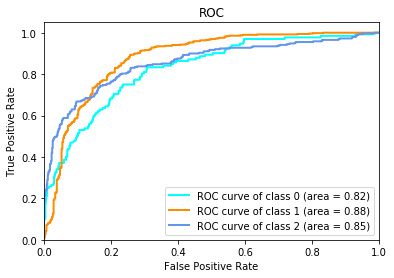

In [241]:
# fit the training dataset on the Naive Bayesian classifier
nb = naive_bayes.MultinomialNB()
nb.fit(X_train_Tfidf, y_train)
# predict the labels on both training and testing dataset
y_fit = nb.predict(X_train_Tfidf)
y_pred = nb.predict(X_test_Tfidf)
# report performance
Metrics(nb, X_train_Tfidf, y_train, y_fit, X_test_Tfidf, y_test, y_pred);

#### 3. Apply SVM classifier to build a sentiment model and show its performance

in-sample confusion matrix for SVC
act\pred | class-0  class-1  class-2
---------------------------
class-0  |     264       56       11
class-1  |       3     1203        3
class-2  |       2       66      513

out-of-sample confusion matrix for SVC
act\pred | class-0  class-1
---------------------------
class-0  |      43       76       13
class-1  |       3      472       14
class-2  |      12      122      155

In and out of sample accuracy, precision, recall and F1-score for SVC
metric      in-sample   out-of-sample
-------------------------------------
accuracy        0.934           0.736
precision       0.937           0.757
recall          0.934           0.736
F1              0.932           0.712


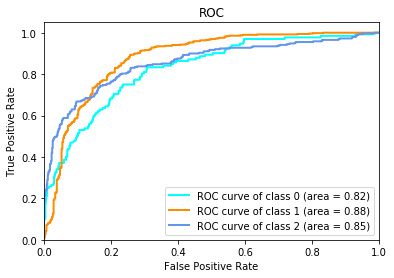

In [242]:
# fit the training dataset on the SVM classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train_Tfidf, y_train)
# predict the labels on both training and testing dataset
y_fit = SVM.predict(X_train_Tfidf)
y_pred = SVM.predict(X_test_Tfidf)
# report performance
Metrics(SVM, X_train_Tfidf, y_train, y_fit, X_test_Tfidf, y_test, y_pred);

Compare the Naive Bayes and SVM model's performance, we could see:  
+ The two classifier's ROC curve looks similiar.  
+ For both training and testing set, the accuracy, precision, recall, F1 score for SVM is higher than Naive Bayes model.   
+ I conclude that SVM has better performance than Naive Bayesian model when for social media sentiment analysis problem.

#### 4. Apply GridSearch to tune parameters for SVM model to improve its performance

In [243]:
# Find the best hyperparameters via Grid-Search
rnd_state = 123
svm_clf = svm.SVC(random_state=rnd_state)
param_grid = {'C':[0.1, 1, 10, 15],
             'gamma':[0.001, 0.01, 0.1, 1],
             'kernel':['rbf', 'poly', 'linear', 'sigmoid']}
grid = GridSearchCV(svm_clf, param_grid, cv=5, n_jobs=10)
grid.fit(X_train_Tfidf, y_train)
print('Best parameters obtained using Grid-Search', grid.best_params_)

Best parameters obtained using Grid-Search {'C': 15, 'gamma': 0.1, 'kernel': 'sigmoid'}


in-sample confusion matrix for SVC
act\pred | class-0  class-1  class-2
---------------------------
class-0  |     314       12        5
class-1  |       1     1208        0
class-2  |       1       15      565

out-of-sample confusion matrix for SVC
act\pred | class-0  class-1
---------------------------
class-0  |      60       56       16
class-1  |      12      459       18
class-2  |      24       95      170

In and out of sample accuracy, precision, recall and F1-score for SVC
metric      in-sample   out-of-sample
-------------------------------------
accuracy        0.984           0.757
precision       0.984           0.760
recall          0.984           0.757
F1              0.984           0.744


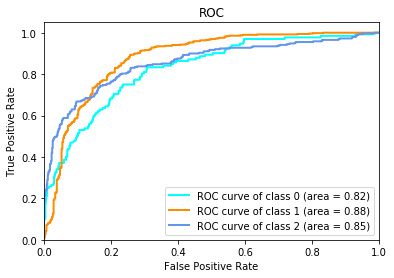

In [244]:
# fit the training dataset on the SVM classifier
svm_clf = svm.SVC(random_state=rnd_state, kernel='rbf', C=10, gamma=0.1, probability=True)
svm_clf.fit(X_train_Tfidf, y_train)

# predict the labels on both training and testing dataset
y_fit = svm_clf.predict(X_train_Tfidf)
y_pred = svm_clf.predict(X_test_Tfidf)

# report performance
Metrics(svm_clf, X_train_Tfidf, y_train, y_fit, X_test_Tfidf, y_test, y_pred);

By applying GridSearch, I find the better hyperparameters for SVM model.  
Use the new parameters to train the data, the in-sample and out-of-sample performance for SVM is better. 

### Visualization

#### 1. Use the wordcloud to visualize the most frequent words

In [251]:
Corpus1 = pd.read_csv('final_data.csv')
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt    
# remove twitter handles (@user)
Corpus1['tidy_tweet'] = np.vectorize(remove_pattern)(Corpus1['text'], "@[\w]*")
# remove special characters, numbers, punctuations
Corpus1['tidy_tweet'] = Corpus1['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
# Removing Short Words
Corpus1['tidy_tweet'] = Corpus1['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# Tokenization
tokenized_tweet = Corpus1['tidy_tweet'].apply(lambda x: x.split())
# Stemming
from nltk.stem.porter import *
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
# stitch these tokens back together
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

Corpus1['tidy_tweet'] = tokenized_tweet
Corpus1.head()

,text,sentiment,tidy_tweet
0,"Eu amo as pessoas que falam que ""ketchup e mai...",positive,pessoa falam ketchup maiones estragam sabor na...
1,RT @ElNacionalWeb: #ServicioPúblico Para bebé...,neutral,#serviciop blico para reci nacida requier cter...
2,RT @jbem1970: yesterday hubby &amp; I went to ...,negative,yesterday hubbi went child ball game after kid...
3,RT @Chitown_Kid_13: Low-income kids gotta worr...,neutral,incom kid gotta worri about they go about get ...
4,RT @BABYB0YBANGTAN: when my mom wakes me up fr...,neutral,when wake from help groceri http


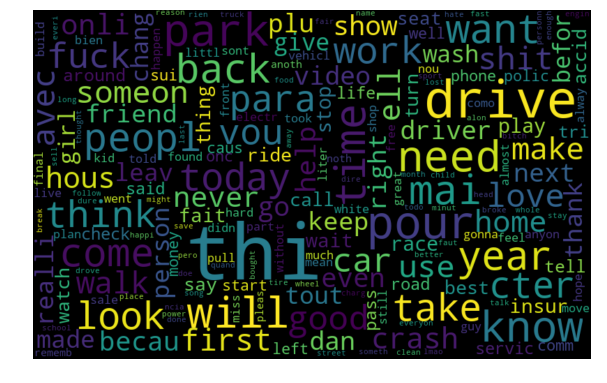

In [252]:
all_words = ' '.join([text for text in Corpus1['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### 2. Visualize preditions made by model

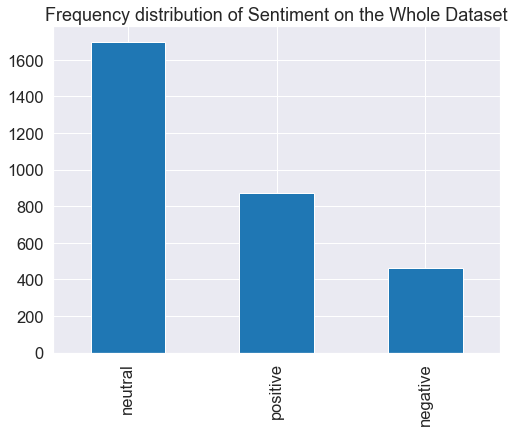

In [300]:
Corpus.sentiment.value_counts().plot.bar(title="Frequency distribution of Sentiment on the Whole Dataset");

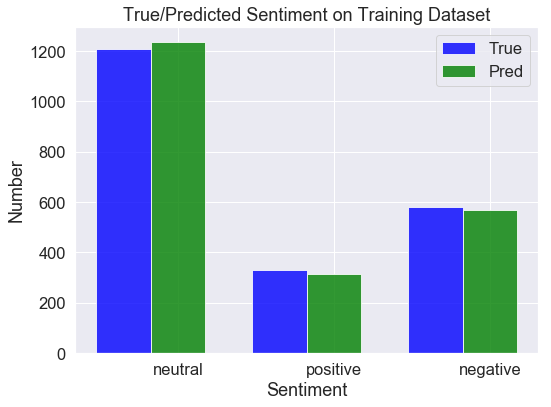

In [303]:
# data to plot
n_groups = 3
means_test = ((y_train==1).sum(), (y_train==0).sum(), (y_train==2).sum())
means_pred = ((y_fit==1).sum(), (y_fit==0).sum(), (y_fit==2).sum())

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_test, bar_width, alpha=opacity, color='b', label='True')

rects2 = plt.bar(index + bar_width, means_pred, bar_width, alpha=opacity, color='g', label='Pred')

plt.xlabel('Sentiment')
plt.ylabel('Number')
plt.title('True/Predicted Sentiment on Training Dataset')
plt.xticks(index + bar_width, ('neutral', 'positive', 'negative'))
plt.legend()
plt.tight_layout()
plt.show()

From the above figure we can see, our model fit the data well on the training set. 

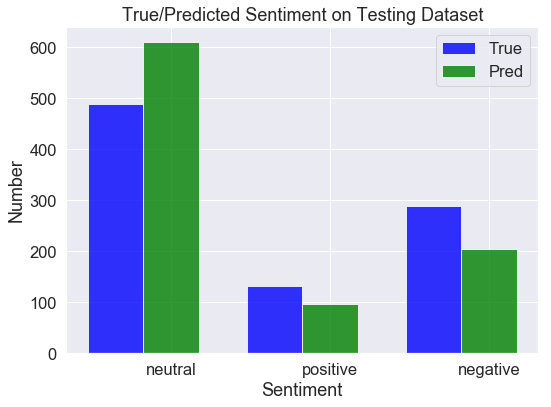

In [304]:
# data to plot
n_groups = 3
means_test = ((y_test==1).sum(), (y_test==0).sum(), (y_test==2).sum())
means_pred = ((y_pred==1).sum(), (y_pred==0).sum(), (y_pred==2).sum())

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_test, bar_width, alpha=opacity, color='b', label='True')

rects2 = plt.bar(index + bar_width, means_pred, bar_width, alpha=opacity, color='g', label='Pred')

plt.xlabel('Sentiment')
plt.ylabel('Number')
plt.title('True/Predicted Sentiment on Testing Dataset')
plt.xticks(index + bar_width, ('neutral', 'positive', 'negative'))
plt.legend()
plt.tight_layout()
plt.show()

From above figure we can see, for testing set, the performance of the model is not as good as for training set.

### Summary

In this project, I use tweets to do social media sentiment analysis. After collecting the original data I need, I first use TextBlob to tag each tweet into Positive, Negative, or Neutral. Then I pre-process the tweets' text, including removing punctuations, numbers, special characters, and short words, then I tokenize all the cleaned tweets in our dataset and perform stemming. Then I split the data and apply Naive Bayesian and SVM model to train the data. I compare their performance and find that SVM can do better work than Naive Bayesian model. So I apply GridSearch on SVM model to see if I can improve its performance further. After finishing all these steps, I visualize the result, and find that on this dataset, negative and positive tweets are less than neutral tweets, and nagative tweets are slightly more than the postive tweets.
